<a href="https://colab.research.google.com/github/Engel02/GANFORFACES/blob/master/GAN_generate_r_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Especificar la ruta al archivo zip en Drive
zip_path = '/content/drive/MyDrive/CELEB_ALL/img_align_celeba.zip'

# Especificar la ruta a la carpeta de destino en Drive
dest_path = '/content/drive/MyDrive/CELEB_ALL/img_align_celeba/'

# Descomprimir el archivo zip usando !unzip
!unzip -q "{zip_path}" -d "{dest_path}"

replace /content/drive/MyDrive/CELEB_ALL/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import os
#from google.colab import drive
#drive.mount('/content/drive')

PIC_DIR = f'drive/MyDrive/CELEB_A_ALL/img_align_celeba/img_align_celeba/'
    
from tqdm import tqdm
from PIL import Image

IMAGES_COUNT = 200000

ORIG_WIDTH = 178
ORIG_HEIGHT = 218
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 64
HEIGHT = 64

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

In [ ]:
images = np.array(images) / 255
print(images.shape)


from matplotlib import pyplot as plt

(9171, 128, 128, 3)


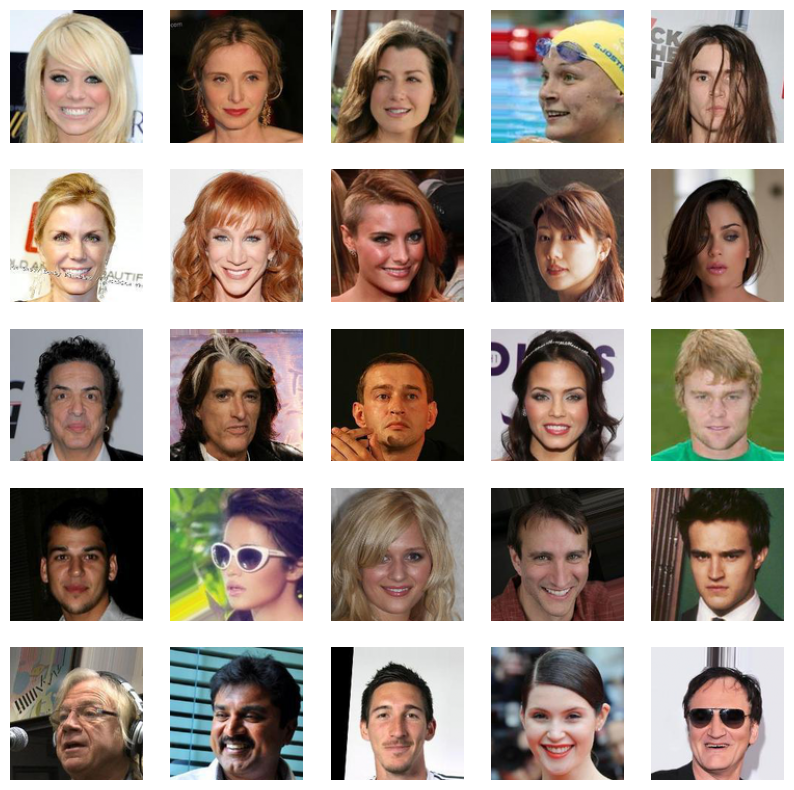

In [ ]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3


In [ ]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(32 * 8 * 8)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 32))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator



generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')


1/1 [==============================] - 0s 19ms/step
50/500: d_loss: 0.4363,  a_loss: 0.7717.  (6.8 sec)
1/1 [==============================] - 0s 19ms/step
100/500: d_loss: 0.6990,  a_loss: 0.7812.  (3.0 sec)
1/1 [==============================] - 0s 19ms/step
150/500: d_loss: 0.7135,  a_loss: 1.3269.  (2.9 sec)
1/1 [==============================] - 0s 32ms/step
200/500: d_loss: 0.6662,  a_loss: 0.7411.  (3.6 sec)
1/1 [==============================] - 0s 27ms/step
250/500: d_loss: 0.6682,  a_loss: 0.8808.  (3.6 sec)
1/1 [==============================] - 0s 19ms/step
300/500: d_loss: 0.5922,  a_loss: 1.0049.  (3.0 sec)
1/1 [==============================] - 0s 20ms/step
350/500: d_loss: 0.5964,  a_loss: 1.1305.  (2.9 sec)
1/1 [==============================] - 0s 20ms/step
400/500: d_loss: 0.7304,  a_loss: 0.8881.  (3.0 sec)
1/1 [==============================] - 0s 31ms/step
450/500: d_loss: 0.6569,  a_loss: 1.0119.  (3.3 sec)
1/1 [==============================] - 0s 32ms/step
500/

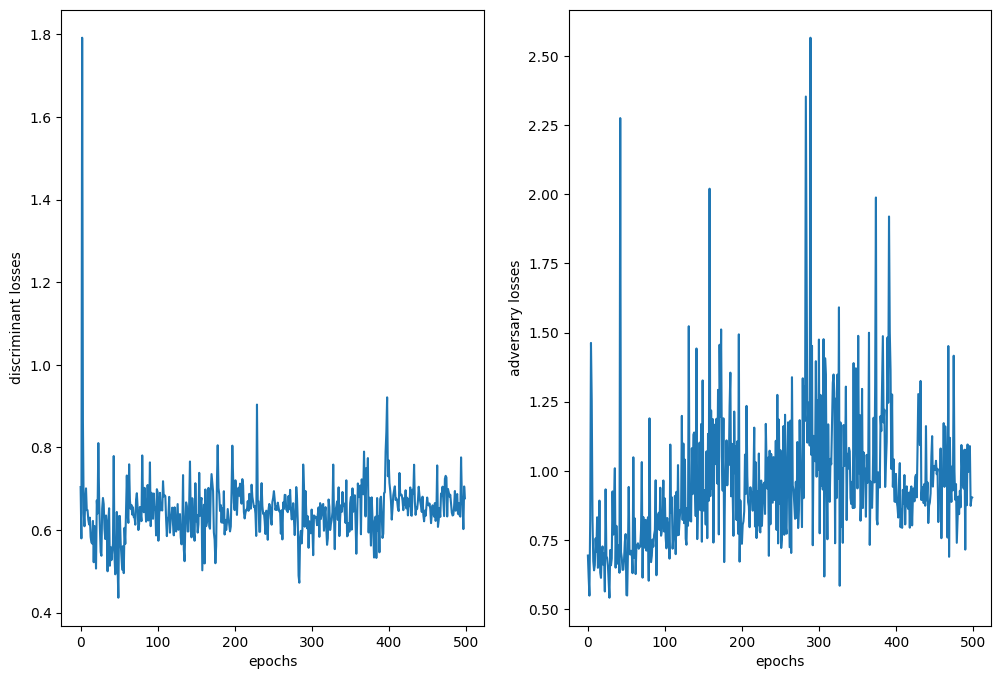

<ipython-input-16-130113ef6ec8>:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))


In [ ]:
import time
iters = 500
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('./drive/MyDrive/gan12.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('drive/MyDrive/visual12.gif', images_to_gif)
shutil.rmtree(RES_DIR)